AirBnB recruiting kaggle
------

https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings

## Load libraries

In [1]:
# Core
from __future__ import print_function
import datetime as DT
import pandas as pd
import numpy as np
import re

# Sklearn
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.discriminant_analysis \
    import LinearDiscriminantAnalysis as LDA\
            , QuadraticDiscriminantAnalysis as QDA
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,Imputer
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
from sklearn.linear_model import LinearRegression

# Metrics
from sklearn.metrics import log_loss, classification_report

# Neural Nets
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.noise import GaussianDropout
from keras.regularizers import l2
from keras.layers.advanced_activations import PReLU

# matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline  

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
class MultiColumnLabelEncoder:
    ''' Create a class that encodes
        labels for a matrix of data
    '''
    def __init__(self, columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here
    
    def get_params(self, deep=True):
        out = dict()
        if self.columns: out['columns'] = columns
        return out

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). 
        '''
        numerics = [np.float16, np.float32, np.float64]
        ints = [np.int16, np.int32, np.int64]
        output = X.copy()
        
        for colname,col in output.iteritems():
            if col.dtype not in numerics+ints:
                # Turn text columns into ints
                output[colname] = LabelEncoder().fit_transform(output[colname])
            elif col.dtype in numerics:
                # handle floats with scaling
                # output[colname] = scale(output[colname])
                pass 
            elif col.dtype in ints:
                pass # leave integers alone
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

## Declare Args

In [3]:
## Files ## 
AGE_GENDER_BUCKETS_FILE = 'Data/age_gender_bkts.csv'
COUNTRIES_FILE = 'Data/countries.csv'
SAMPLE_SUBMISSION_FILE = 'Data/sample_submission.csv'
SESSIONS_FILE = 'Data/sessions.csv'
TEST_DATA_FINAL_FILE = 'Data/test_users.csv'
TRAIN_DATA_FILE = 'Data/train_users.csv'

## Model args ##
TEST_N = 20000

## Fields ## 
USER_COLUMNS = ['id',
 'date_account_created',
 'timestamp_first_active',
 'date_first_booking',
 'gender',
 'age',
 'signup_method',
 'signup_flow',
 'language',
 'affiliate_channel',
 'affiliate_provider',
 'first_affiliate_tracked',
 'signup_app',
 'first_device_type',
 'first_browser']
TARGET_COLUMN = ['country_destination']

SESSION_COLUMNS = ['user_id',
 'action',
 'action_type',
 'action_detail',
 'device_type',
 'secs_elapsed']

AGE_BUCKET_COLUMNS = ['age_bucket',
 'country_destination',
 'gender',
 'population_in_thousands',
 'year']

## Read data


In [4]:
## Read user data ## 
train_full = pd.read_csv(TRAIN_DATA_FILE).sort_values('id')
train_set, train_target = train_full[TEST_N:][USER_COLUMNS+TARGET_COLUMN],\
    train_full[TEST_N:][TARGET_COLUMN]
test_set, test_target = train_full[:TEST_N][USER_COLUMNS+TARGET_COLUMN],\
    train_full[:TEST_N][TARGET_COLUMN]

In [5]:
## Read in data to predict for submission ##
final_test_set = pd.read_csv(TEST_DATA_FINAL_FILE)

In [6]:
## Read supplemental datasets ## 
countries = pd.read_csv(COUNTRIES_FILE)
age_buckets = pd.read_csv(AGE_GENDER_BUCKETS_FILE)

In [7]:
## Read session data ##
sessions = pd.read_csv(SESSIONS_FILE)

#### Sessions

#### User data

In [8]:
train_set.shape

(151239, 16)

In [9]:
train_set.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
83959,49e9ggnrzw,2013-06-13,20130613014311,NaN,-unknown-,NaN,basic,0,en,direct,direct,product,Web,Mac Desktop,Safari,NDF
58859,49ecjdmxki,2013-02-02,20130202085835,NaN,-unknown-,NaN,basic,0,zh,direct,direct,untracked,Web,iPad,Mobile Safari,NDF
26389,49eeh6iy30,2012-06-03,20120603144001,NaN,FEMALE,24,basic,0,en,direct,direct,untracked,Web,Windows Desktop,IE,NDF
9729,49ej7td7yw,2011-09-18,20110918181455,NaN,MALE,26,facebook,2,en,direct,direct,NaN,Web,Other/Unknown,-unknown-,NDF
49576,49f1u9p752,2012-11-21,20121121211308,2012-11-22,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [10]:
train_set.index = train_set['id']
test_set.index = test_set['id']
final_test_set.index = final_test_set['id']

In [11]:
train_set['gender'].value_counts()

-unknown-    65345
FEMALE       46188
MALE         39494
OTHER          212
Name: gender, dtype: int64

In [12]:
train_set.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
id,,,,,,,,,,,,,,,,
49e9ggnrzw,49e9ggnrzw,2013-06-13,20130613014311,NaN,-unknown-,NaN,basic,0,en,direct,direct,product,Web,Mac Desktop,Safari,NDF
49ecjdmxki,49ecjdmxki,2013-02-02,20130202085835,NaN,-unknown-,NaN,basic,0,zh,direct,direct,untracked,Web,iPad,Mobile Safari,NDF
49eeh6iy30,49eeh6iy30,2012-06-03,20120603144001,NaN,FEMALE,24,basic,0,en,direct,direct,untracked,Web,Windows Desktop,IE,NDF
49ej7td7yw,49ej7td7yw,2011-09-18,20110918181455,NaN,MALE,26,facebook,2,en,direct,direct,NaN,Web,Other/Unknown,-unknown-,NDF
49f1u9p752,49f1u9p752,2012-11-21,20121121211308,2012-11-22,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [13]:
train_set.loc[train_set['age']>115,['age']] = np.nan
test_set.loc[test_set['age']>115,['age']] = np.nan
final_test_set.loc[final_test_set['age']>115,['age']] = np.nan

In [14]:
train_set['date_created'] = pd.to_datetime(train_set['date_account_created'])
train_set['date_first_booking'] = pd.to_datetime(train_set['date_first_booking'])
train_set['year_created'] = train_set['date_created'].dt.year
train_set['month_created'] = train_set['date_created'].dt.month
train_set['year_first_booking'] = train_set['date_first_booking'].dt.year
train_set['month_first_booking'] = train_set['date_first_booking'].dt.month
train_set['days_to_first_booking'] = train_set['date_first_booking']-train_set['date_created']

# repeat with test 
test_set['date_created'] = pd.to_datetime(test_set['date_account_created'])
test_set['date_first_booking'] = pd.to_datetime(test_set['date_first_booking'])
test_set['year_created'] = test_set['date_created'].dt.year
test_set['month_created'] = test_set['date_created'].dt.month
test_set['year_first_booking'] = test_set['date_first_booking'].dt.year
test_set['month_first_booking'] = test_set['date_first_booking'].dt.month
test_set['days_to_first_booking'] = test_set['date_first_booking']-test_set['date_created']

# repeat with final test
final_test_set['date_created'] = pd.to_datetime(final_test_set['date_account_created'])
final_test_set['date_first_booking'] = pd.to_datetime(final_test_set['date_first_booking'])
final_test_set['year_created'] = final_test_set['date_created'].dt.year
final_test_set['month_created'] = final_test_set['date_created'].dt.month
final_test_set['year_first_booking'] = final_test_set['date_first_booking'].dt.year
final_test_set['month_first_booking'] = final_test_set['date_first_booking'].dt.month
final_test_set['days_to_first_booking'] = final_test_set['date_first_booking']-test_set['date_created']

In [15]:
train_set.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,signup_app,first_device_type,first_browser,country_destination,date_created,year_created,month_created,year_first_booking,month_first_booking,days_to_first_booking
id,,,,,,,,,,,,,,,,,,,,,
49e9ggnrzw,49e9ggnrzw,2013-06-13,20130613014311,NaT,-unknown-,NaN,basic,0,en,direct,...,Web,Mac Desktop,Safari,NDF,2013-06-13,2013,6,NaN,NaN,NaT
49ecjdmxki,49ecjdmxki,2013-02-02,20130202085835,NaT,-unknown-,NaN,basic,0,zh,direct,...,Web,iPad,Mobile Safari,NDF,2013-02-02,2013,2,NaN,NaN,NaT
49eeh6iy30,49eeh6iy30,2012-06-03,20120603144001,NaT,FEMALE,24,basic,0,en,direct,...,Web,Windows Desktop,IE,NDF,2012-06-03,2012,6,NaN,NaN,NaT
49ej7td7yw,49ej7td7yw,2011-09-18,20110918181455,NaT,MALE,26,facebook,2,en,direct,...,Web,Other/Unknown,-unknown-,NDF,2011-09-18,2011,9,NaN,NaN,NaT
49f1u9p752,49f1u9p752,2012-11-21,20121121211308,2012-11-22,-unknown-,NaN,basic,0,en,direct,...,Web,Mac Desktop,Chrome,US,2012-11-21,2012,11,2012,11,1 days


In [16]:
train_set['days_to_first_booking'].value_counts()

0 days       14937
1 days       10585
2 days        4708
3 days        2923
4 days        2165
5 days        1676
6 days        1308
7 days        1219
8 days         957
9 days         748
10 days        663
11 days        574
12 days        495
13 days        492
14 days        484
15 days        398
16 days        374
17 days        321
19 days        288
21 days        285
18 days        270
20 days        260
28 days        213
24 days        208
22 days        207
29 days        206
23 days        205
25 days        200
27 days        199
26 days        170
             ...  
227 days        25
264 days        25
363 days        25
252 days        25
219 days        25
300 days        22
341 days        22
255 days        22
-4 days          3
-3 days          2
-109 days        1
-308 days        1
-261 days        1
-77 days         1
-85 days         1
-338 days        1
-208 days        1
-74 days         1
-18 days         1
-11 days         1
-95 days         1
-37 days    

In [17]:
train_set.loc[train_set['days_to_first_booking']<pd.Timedelta(0)\
              ,['days_to_first_booking']] = np.nan
train_set['days_to_first_booking'] = \
                train_set['days_to_first_booking'].astype('timedelta64[D]')

test_set.loc[test_set['days_to_first_booking']<pd.Timedelta(0)\
              ,['days_to_first_booking']] = np.nan
test_set['days_to_first_booking'] = \
                test_set['days_to_first_booking'].astype('timedelta64[D]')

final_test_set.loc[final_test_set['days_to_first_booking']<pd.Timedelta(0)\
              ,['days_to_first_booking']] = np.nan
final_test_set['days_to_first_booking'] = \
                final_test_set['days_to_first_booking'].astype('timedelta64[D]')

#### age buckets

In [18]:
age_buckets.head()

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1,2015
1,95-99,AU,male,9,2015
2,90-94,AU,male,47,2015
3,85-89,AU,male,118,2015
4,80-84,AU,male,199,2015


In [19]:
age_buckets['age_merge'] = (np.floor(\
                  np.array([int(re.split(r'[-+]',str(x))[0]) \
                  for x in age_buckets['age_bucket']]\
            )/10)*10).astype('int')

In [20]:
age_buckets.index = age_buckets['age_merge'].astype('string') \
            +'-'+age_buckets['country_destination'] \
            +'-'+age_buckets['gender'].str.lower()

In [21]:
for c in set(countries['country_destination']):
    train_set['age_merge'+'-'+c] = (
                        np.floor(\
                            train_set['age']/10)*10\
                        )\
                            .fillna(0)\
                            .astype('int')\
                            .astype('string') \
                        +'-'+c \
                        +'-'+train_set['gender'].str.lower()
    test_set['age_merge'+'-'+c] = (
                        np.floor(\
                            test_set['age']/10)*10\
                        )\
                            .fillna(0)\
                            .astype('int')\
                            .astype('string') \
                        +'-'+c \
                        +'-'+test_set['gender'].str.lower()
    final_test_set['age_merge'+'-'+c] = (
                        np.floor(\
                            final_test_set['age']/10)*10\
                        )\
                            .fillna(0)\
                            .astype('int')\
                            .astype('string') \
                        +'-'+c \
                        +'-'+test_set['gender'].str.lower()

In [22]:
age_buckets = age_buckets[[
        'age_merge' \
        ,'country_destination' \
        ,'gender' \
        ,'population_in_thousands']] \
    .groupby(['age_merge','country_destination','gender']).sum()

In [23]:
age_buckets.index = pd.Series([ str(i[0])+'-'+i[1]+'-'+i[2] for i in age_buckets.index])

In [24]:
for c in set(countries['country_destination']):
    train_set = pd.merge(
        train_set \
         , age_buckets \
         , left_on=['age_merge'+'-'+c] \
         , right_index=True \
         , how='outer' \
         , suffixes=(c,c)
    )
    test_set = pd.merge(
        test_set \
         , age_buckets \
         , left_on=['age_merge'+'-'+c] \
         , right_index=True \
         , how='outer' \
         , suffixes=(c,c)
    )
    final_test_set = pd.merge(
        final_test_set \
         , age_buckets \
         , left_on=['age_merge'+'-'+c] \
         , right_index=True \
         , how='left' \
         , suffixes=(c,c)
    )
print(train_set.shape)

(153219, 42)


In [25]:
train_set = train_set.drop_duplicates(['id'])
test_set = test_set.drop_duplicates(['id'])

In [26]:
train_set['population_estimate'] = 0
test_set['population_estimate'] = 0
final_test_set['population_estimate'] = 0
for c in set(countries['country_destination']):
    try:
        train_set.loc[:,'population_estimate'] = \
            train_set.loc[:,'population_estimate']\
            +np.nansum(train_set.loc[:,'population_in_thousands'+c]\
                       ,axis=1)
        test_set.loc[:,'population_estimate'] = \
            test_set.loc[:,'population_estimate']\
            +np.nansum(test_set.loc[:,'population_in_thousands'+c]\
                       ,axis=1)
        final_test_set.loc[:,'population_estimate'] = \
            final_test_set.loc[:,'population_estimate']\
            +np.nansum(final_test_set.loc[:,'population_in_thousands'+c]\
                       ,axis=1)
    except KeyError:
        pass

#### Add country features

In [27]:
countries

,country_destination,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
0,AU,-26.853388,133.275160,15297.7440,7741220,eng,0.00
1,CA,62.393303,-96.818146,2828.1333,9984670,eng,0.00
2,DE,51.165707,10.452764,7879.5680,357022,deu,72.61
3,ES,39.896027,-2.487694,7730.7240,505370,spa,92.25
4,FR,46.232193,2.209667,7682.9450,643801,fra,92.06
5,GB,54.633220,-3.432277,6883.6590,243610,eng,0.00
6,IT,41.873990,12.564167,8636.6310,301340,ita,89.40
7,NL,52.133057,5.295250,7524.3203,41543,nld,63.22
8,PT,39.553444,-7.839319,7355.2534,92090,por,95.45
9,US,36.966427,-95.844030,0.0000,9826675,eng,0.00


In [28]:
set(train_set['language'])

{nan,
 'ca',
 'cs',
 'da',
 'de',
 'el',
 'en',
 'es',
 'fi',
 'fr',
 'hu',
 'id',
 'is',
 'it',
 'ja',
 'ko',
 'nl',
 'no',
 'pl',
 'pt',
 'ru',
 'sv',
 'th',
 'tr',
 'zh'}

#### Add session data

In [29]:
sessions.shape

(5600850, 6)

In [30]:
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,ailzdefy6o,similar_listings,data,similar_listings,Windows Desktop,255
1,ailzdefy6o,similar_listings,data,similar_listings,Windows Desktop,183
2,ailzdefy6o,ajax_refresh_subtotal,click,change_trip_characteristics,Windows Desktop,175570
3,ailzdefy6o,show,NaN,NaN,Windows Desktop,86
4,ailzdefy6o,personalize,data,wishlist_content_update,Windows Desktop,1535


In [31]:
cf = ['action','action_type','action_detail','device_type']
s = sessions[cf].copy().fillna('missing')
mcl = MultiColumnLabelEncoder()
ohe = OneHotEncoder()
x = ohe.fit_transform(
    mcl.fit_transform(s)
).todense()

In [32]:
try:
    sessions_new = pd.read_csv('Data/sessions_new.csv',index_col=0)
except IOError:
    sessions_new = []

In [33]:
run = True if len(sessions_new)==0 else False

In [34]:
if run:
    n = 100
    loops = sessions.shape[0]//n*np.arange(n)

    o = []
    start_time = DT.datetime.now()
    for i,l in enumerate(loops):
        try:
            a,b = loops[i],loops[i+1]
        except:
            a,b = loops[i],sessions.shape[0]

        sessions_new = pd.DataFrame(np.concatenate(\
            (
                sessions[['user_id']][a:b]\
                , x[a:b]\
                , sessions[['secs_elapsed']][a:b]
            )
            , axis=1
        ))
        sessions_grouped = sessions_new.groupby([0]).sum()
        o.append(sessions_grouped)

        if i%10==0:
            this_time = DT.datetime.now()
            time_change = (this_time - start_time).seconds
            per_second = b*1.0 / (time_change)
            total_time = sessions.shape[0] / per_second / 60
            pct = b*1.0 / sessions.shape[0]
            print('finished {}%, {} mins est. time remaining'\
                    .format(round(pct*100,2)\
                            ,(1-pct)*total_time))
    sessions_new = pd.concat(o,ignore_index=True)
    sessions_new['user_id'] = pd.concat(o).index
    sessions_new = sessions_new.groupby('user_id').sum()
    sessions_new.to_csv('Data/sessions_new.csv',index=True,header=True)

In [35]:
target = pd.DataFrame({'country_destination':train_set['country_destination']})
target.index = train_set['id']
merged = pd.merge(\
            sessions_new\
            , target\
            , how='inner'\
            , left_index=True
            , right_index=True
         )
merged.head()

,1,2,3,4,5,6,7,8,9,10,...,478,479,480,481,482,483,484,485,486,country_destination
49gzikhjfp,0,0,0,0,0,0,0,0,0,0,...,19,0,0,0,0,0,0,0,570756,US
49ixadwceh,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2622468,NDF
49laq7wdzs,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,110,0,0,2060159,NDF
49r4cggdc9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,10,0,73213,NDF
49sxqimts6,0,0,0,0,0,0,0,0,0,0,...,15,0,0,0,0,0,0,0,121461,NDF


In [36]:
merged.describe()

,1,2,3,4,5,6,7,8,9,10,...,477,478,479,480,481,482,483,484,485,486
count,27568.000000,27568.000000,27568.000000,27568.000000,27568.000000,27568.000000,27568,27568,27568,27568,...,27568.000000,27568.000000,27568,27568.000000,27568.000000,27568.000000,27568.000000,27568.000000,27568.000000,26910.000000
mean,0.015997,0.003700,0.017665,0.006457,0.000544,0.070662,0,0,0,0,...,0.223121,28.651480,0,0.315946,19.315656,0.001596,4.614227,3.039575,0.031087,1449033.382869
std,0.356011,0.101432,0.270051,0.160581,0.023320,0.354295,0,0,0,0,...,6.194284,73.825563,0,5.732309,56.886660,0.078049,30.433976,30.206527,2.152512,1810286.867621
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,...,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,...,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,241873.750000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,...,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,856595.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,...,0.000000,24.000000,0,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,1981334.000000
max,47.000000,7.000000,19.000000,12.000000,1.000000,12.000000,0,0,0,0,...,504.000000,2085.000000,0,258.000000,1600.000000,6.000000,1382.000000,1366.000000,224.000000,31393292.000000


In [37]:
np.max(np.array(merged)[:,:-1])

8100419.0

In [38]:
ss = StandardScaler(with_mean=False)
ii = Imputer(strategy='most_frequent')
lda = LDA()
p = Pipeline([('ii',ii),('ss', ss)])
merged_new = p.fit_transform(np.array(merged)[:,:-1])
l = lda.fit_transform(merged_new, np.array(merged)[:,-1:])

/Library/Python/2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Python/2.7/site-packages/sklearn/discriminant_analysis.py:453: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/Library/Python/2.7/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [39]:
sessions_lda = pd.DataFrame(l\
                            ,index=merged.index\
                            ,columns=[ 'lda_'+str(i) \
                                      for i in range(l.shape[1]) ])

In [40]:
sessions_lda.head()

,lda_0,lda_1,lda_2,lda_3,lda_4,lda_5,lda_6,lda_7,lda_8,lda_9,lda_10
49gzikhjfp,-1.511577,-0.014276,-0.618227,-0.180042,-0.821586,-0.008823,-0.260880,0.498179,0.371482,-2.182412,1.263511
49ixadwceh,1.168552,-0.449284,-0.309742,0.267128,-0.002766,0.135722,0.253867,-0.099542,0.010095,0.548047,0.021563
49laq7wdzs,0.019478,0.482780,1.105103,-0.074633,0.923707,0.123424,-1.808378,-0.335312,0.058834,-0.323411,1.148811
49r4cggdc9,0.936202,-0.229380,-0.044153,0.051209,-0.037806,-0.027711,0.410309,0.026468,0.091323,-0.546221,-0.593118
49sxqimts6,0.674172,0.059456,0.116421,-0.092604,0.009533,-0.186448,-0.045982,0.068524,0.228748,-0.203300,0.054418


In [41]:
pca = PCA(n_components=1)
p = pca.fit_transform(sessions_lda)

In [42]:
t = pd.merge(\
            train_set\
            , pd.DataFrame({'lda':p[:,0]},index=sessions_lda.index)\
            , how='inner'\
            , left_index=True
            , right_index=True
    )

In [48]:
cols = [
 'gender',
 'age',
 #'signup_method',
 'signup_flow',
 'language',
 'affiliate_channel',
 'affiliate_provider',
 'first_affiliate_tracked',
 'signup_app',
 'first_device_type',
 'first_browser',
 'year_created' ,
 'month_created' ,
 'year_first_booking' ,
 'month_first_booking' ,
 'days_to_first_booking',
 'population_estimate'
]
t[cols+['lda']].head()

,gender,age,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,year_created,month_created,year_first_booking,month_first_booking,days_to_first_booking,population_estimate,lda
49fhm2fb0y,-unknown-,19,0,en,direct,direct,untracked,Web,Windows Desktop,Firefox,2014,2,2014,2,0,0,-2.057951
49gzikhjfp,-unknown-,NaN,0,en,direct,direct,untracked,Web,Mac Desktop,Safari,2014,2,2014,2,0,0,-1.511577
49ixadwceh,-unknown-,NaN,23,en,direct,direct,untracked,Android,Other/Unknown,-unknown-,2014,2,NaN,NaN,NaN,0,1.168552
49k9gpxjva,-unknown-,35,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,2014,2,2014,2,0,0,-1.969753
49laq7wdzs,-unknown-,NaN,0,en,sem-brand,google,linked,Web,iPhone,Mobile Safari,2014,3,NaN,NaN,NaN,0,0.019478


In [49]:
lm = LinearRegression()
mcl = MultiColumnLabelEncoder()
mm = MinMaxScaler()
ohe = OneHotEncoder()
ss = StandardScaler(with_mean=False)
ii = Imputer(strategy='most_frequent')
p = Pipeline([('mcl',mcl)\
              ,('ii',ii)\
              ,('mm',mm)\
              ,('ss', ss)\
              ])
lda = p.fit_transform(t[cols])
lda_lm = lm.fit(lda,t['lda'])

#### Compile dataset

In [45]:
cat_cols = [
    'gender',
    #'signup_method',
    'signup_flow',
    'language',
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'signup_app',
    'first_device_type',
    'first_browser',
    'year_created',
    'month_created',
    'year_first_booking' ,
    'month_first_booking' ,
]
num_cols = [
    'age',
    'days_to_first_booking',
    'population_estimate' 
]
print(train_set[cat_cols + num_cols].shape)

(151240, 16)


In [46]:
train_set[cat_cols+num_cols].head()

,gender,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,year_created,month_created,year_first_booking,month_first_booking,age,days_to_first_booking,population_estimate
id,,,,,,,,,,,,,,,,
49e9ggnrzw,-unknown-,0,en,direct,direct,product,Web,Mac Desktop,Safari,2013,6,NaN,NaN,NaN,NaN,0
49ecjdmxki,-unknown-,0,zh,direct,direct,untracked,Web,iPad,Mobile Safari,2013,2,NaN,NaN,NaN,NaN,0
49f1u9p752,-unknown-,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,2012,11,2012,11,NaN,1,0
49f3z9m1rn,-unknown-,0,en,direct,direct,untracked,Web,Mac Desktop,Safari,2013,7,NaN,NaN,NaN,NaN,0
49fm4jyyoq,-unknown-,0,en,direct,direct,untracked,Web,Windows Desktop,Firefox,2013,4,NaN,NaN,NaN,NaN,0


In [50]:
tr_lda = p.fit_transform(train_set[cat_cols+num_cols])
tst_lda = p.transform(test_set[cat_cols+num_cols])
final_tst_lda = p.transform(final_test_set[cat_cols+num_cols])
lda = lda_lm.predict(tr_lda)
tst_lda = lda_lm.predict(tst_lda)
final_tst_lda = lda_lm.predict(final_tst_lda)
train_set['session_lda'] = lda
test_set['session_lda'] = tst_lda
final_test_set['session_lda'] = final_tst_lda

In [51]:
mcl = MultiColumnLabelEncoder()
mm = MinMaxScaler()
ohe = OneHotEncoder()
ss = StandardScaler(with_mean=False)
ii = Imputer(strategy='most_frequent')
ii2 = Imputer(strategy='mean')
p = Pipeline([('mcl',mcl),('ii',ii),('ohe',ohe)])
p2 = Pipeline([('ii',ii2),('ss',ss),('mm',mm)])

In [52]:
z = p.fit_transform(train_set[cat_cols])
zB = p2.fit_transform(train_set[num_cols+['session_lda']])
z2 = p.transform(test_set[cat_cols])
z2B = p2.transform(test_set[num_cols+['session_lda']])
z3 = p.transform(final_test_set[cat_cols])
z3B = p2.transform(final_test_set[num_cols+['session_lda']])

train_set_new = np.concatenate((z.todense(),zB),axis=1)
test_set_new = np.concatenate((z2.todense(),z2B),axis=1)
final_test_set_new = np.concatenate((z3.todense(),z3B),axis=1)

In [53]:
print(train_set_new[:,:].shape)

(151240, 187)


In [54]:
train_target = train_set['country_destination'].fillna('unknown')
test_target = test_set['country_destination'].fillna('unknown')
print(train_target.shape)

(151240,)


In [55]:
lda = LDA()
l = lda.fit_transform(train_set_new, np.array(train_target))

In [56]:
s = np.sum(lda.coef_**2,axis=0)
s_sort = sorted(enumerate(s),key=lambda x: x[1],reverse=True)
s_sort[:25]

[(186, 306788.34257762949),
 (183, 99217.957006919532),
 (184, 41296.221354054127),
 (74, 39764.659526925781),
 (83, 38053.060707085497),
 (95, 20511.838796352662),
 (96, 20195.429848776268),
 (98, 19539.23631739982),
 (126, 18784.293429632969),
 (107, 15655.857957247472),
 (88, 10809.276260304199),
 (125, 9264.1601201831745),
 (185, 8713.3132179981094),
 (100, 8501.6987928302333),
 (173, 6401.0442651488556),
 (21, 5285.94738711024),
 (19, 5157.0250739765097),
 (85, 4151.7358482208929),
 (20, 3927.6572955708511),
 (145, 3609.1873963957541),
 (182, 3143.9144601352855),
 (143, 2885.807178817252),
 (135, 2881.9757959698322),
 (136, 2837.2628319914838),
 (1, 2822.5409593612953)]

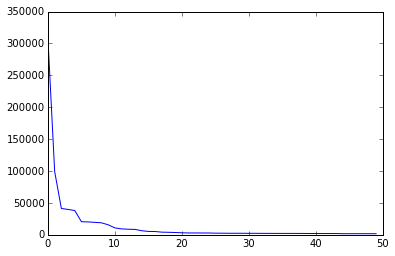

In [57]:
plt.plot(sorted(s,reverse=True)[:50])

In [58]:
features = [i[0] for i in s_sort if i[1]>=min(sorted(s,reverse=True)[:20])]
train_set_new[:,features].shape

(151240, 25)

In [59]:
pca = PCA(n_components=20)
p = pca.fit_transform(train_set_new[:,features])
p_tst = pca.transform(test_set_new[:,features])
p_final_tst = pca.transform(final_test_set_new[:,features])

In [60]:
print(np.cumsum(pca.explained_variance_ratio_))

array([ 0.25860685,  0.45541854,  0.53615337,  0.58804007,  0.63691991,
        0.68364295,  0.72831342,  0.77226859,  0.81557294,  0.85747756])

### Test prediction model 

In [61]:
lb = LabelBinarizer()
cat = lb.fit_transform(np.array(train_target))
cat_tst = lb.transform(np.array(test_target))

In [ ]:
n = p.shape[1]
nn = Sequential()
nn.add(GaussianDropout(0.5))
nn.add(Dense(input_dim=n, output_dim=32, init="uniform"))
nn.add(Activation("tanh"))
nn.add(PReLU((32,)))
nn.add(Dropout(0.3))
nn.add(Dense(input_dim=32, output_dim=13, init="glorot_uniform"))
nn.add(Activation("softmax"))
nn.compile(loss='categorical_crossentropy', optimizer='sgd')
nn.fit(p, cat, nb_epoch=10)

Epoch 0
151240/151240 [==============================] - 2s - loss: 1.4552     
Epoch 1
151240/151240 [==============================] - 2s - loss: 1.1930     
Epoch 2
151240/151240 [==============================] - 2s - loss: 1.1814     
Epoch 3
151240/151240 [==============================] - 2s - loss: 1.1757     
Epoch 4
151240/151240 [==============================] - 2s - loss: 1.1710     
Epoch 5
151240/151240 [==============================] - 2s - loss: 1.1674     
Epoch 6
151240/151240 [==============================] - 2s - loss: 1.1659     
Epoch 7
151240/151240 [==============================] - 2s - loss: 1.1636     
Epoch 8
151240/151240 [==============================] - 2s - loss: 1.1610     
Epoch 9
121600/151240 [=======================>......] - ETA: 0s - loss: 1.1589

In [ ]:
p_pred = nn.predict(p_tst)
p_pred_i = lb.inverse_transform(p_pred)

In [ ]:
print(log_loss(p_pred_i, np.array(test_target)))
print(np.mean(p_pred_i == np.array(test_target)))
print(classification_report(p_pred_i,np.array(test_target)))

In [ ]:
f_pred = nn.predict(p_final_tst)
f_pred_i = lb.inverse_transform(f_pred)

In [ ]:
f_pred_df = pd.DataFrame(f_pred,columns=sorted(set(train_target)))
f_pred_df.index = np.array(final_test_set['id'])

In [ ]:
s = f_pred_df.stack()

In [ ]:
s.to_csv('Data/submission.csv',index=True)